### Importing libraries

In [1]:
import openpyxl as op
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
import numpy as np
import pandas as pd
from openpyxl import Workbook
import re
from IPython.display import set_matplotlib_formats
import collections
import plotly.graph_objects as go
import os
import glob
import plotly.express as px
import statistics
from openpyxl.utils.dataframe import dataframe_to_rows

### Statistics

In [6]:
pblocks_table = pd.read_csv('../B_hybrid_aln_gencode_v41/pblocks.tsv', sep='\t')

unique_isoform_pair = pd.unique(pblocks_table['other'])

len(unique_isoform_pair)

47048

### Plot 1

<AxesSubplot: xlabel='pblock_number', ylabel='count'>

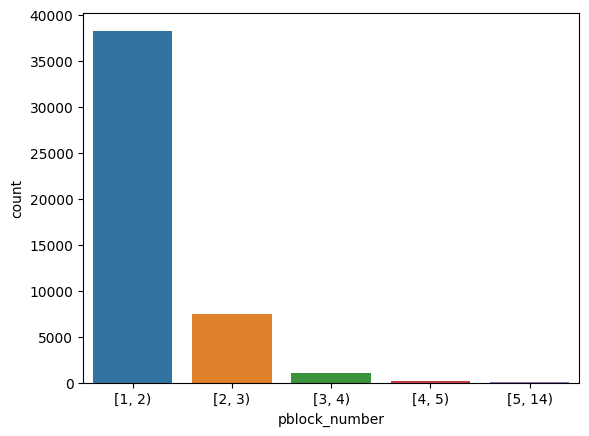

In [25]:
q = 0.99
pblock_per_isoform = pblocks_table.groupby(['anchor', 'other']).pblock_number.agg(('count'))
sns.countplot(x=pd.cut(pblock_per_isoform, bins=[1, 2, 3, 4, 5, 14], right=False))


### Plot 2: 

(0.0, 1986.6500000000015)

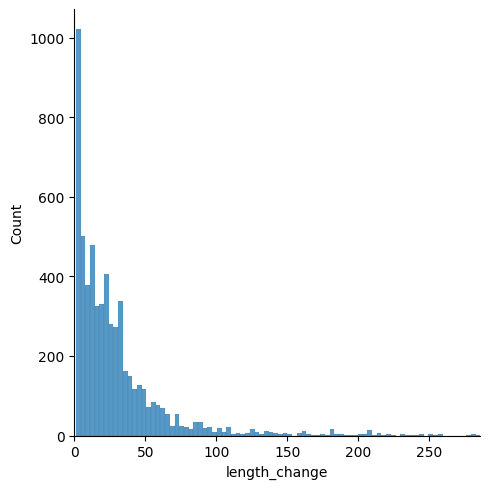

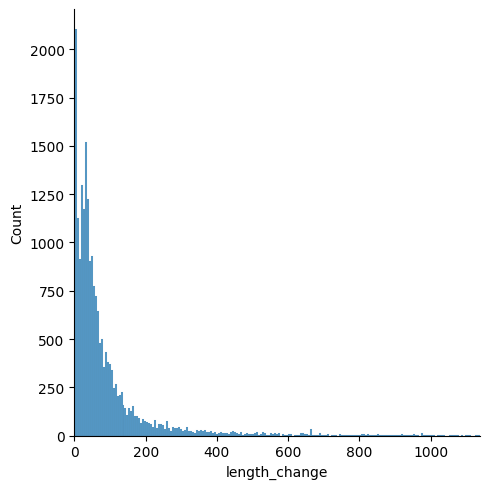

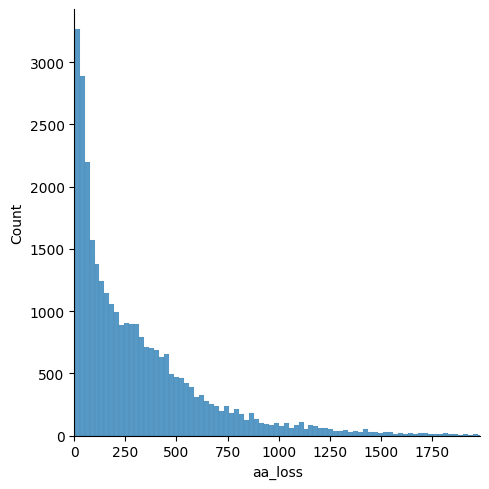

In [28]:
q = 0.99

x = pblocks_table[pblocks_table['pblock_category']=='INSERTION']['length_change']
sns.displot(x=x)
plt.xlim(0, x.quantile(q))

x = pblocks_table[pblocks_table['pblock_category']=='DELETION']['length_change'].abs()
sns.displot(x=x)
plt.xlim(0, x.quantile(q))

x = pblocks_table[pblocks_table['pblock_category']=='SUBSTITUTION']['aa_loss']
sns.displot(x=x)
plt.xlim(0, x.quantile(q))

### Plot 3: 

<AxesSubplot: xlabel='aa_loss', ylabel='aa_gain'>

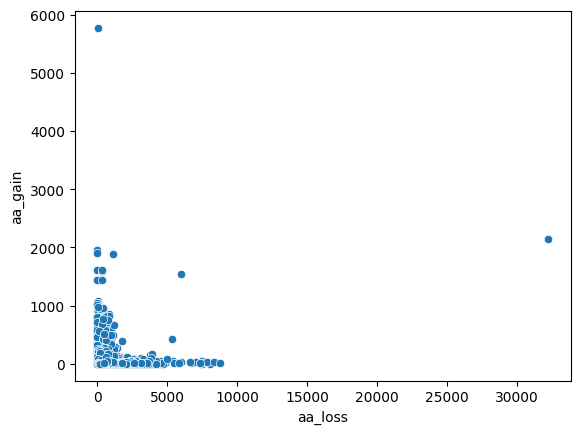

In [10]:
pblock_per_isoform=pblocks_table.groupby(['anchor', 'other'])
sns.scatterplot(data=pblocks_table[pblocks_table["pblock_category"]=="SUBSTITUTION"], x="aa_loss", y='aa_gain')

### Alt to pie chart

<AxesSubplot: xlabel='pblock_category', ylabel='count'>

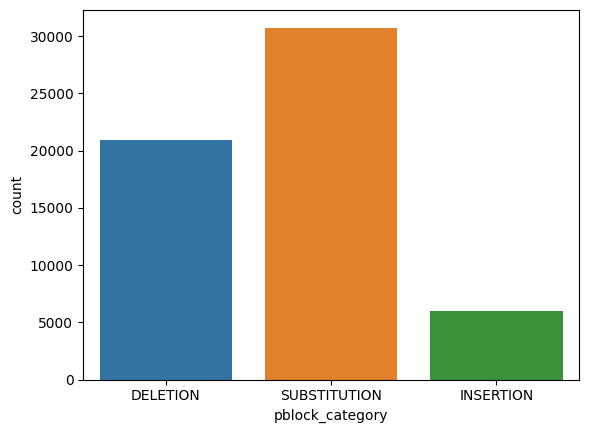

In [12]:
sns.countplot(x=pblocks_table['pblock_category'])